In [6]:
# Sunspot Gamma modelling with MCMC (Metropolis-Hastings)
# Works with local SN_m_tot_V2.0.csv or will try to download if missing.
# Requires: numpy, pandas, matplotlib, scipy, requests (requests only for auto-download)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
import os



In [7]:
# Optional: to auto-download if file missing
try:
    import requests
except Exception:
    requests = None

# ----------------- USER SETTINGS -----------------
CSV_PATH = "SN_m_tot_V2.0.csv"   # local filename (if present)
CSV_URL = "https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv"  # official SILSO raw CSV (try)
SEP = ";"  # many SILSO files use semicolon; if parse fails switch to ','
CYCLE_YEARS = 12
MONTHS_PER_YEAR = 12
CYCLE_LEN = CYCLE_YEARS * MONTHS_PER_YEAR
EPS = 1e-8  # small offset to avoid zeros
# MCMC settings
N_ITER = 40000      # total MH samples (including burn-in)
BURN_IN = 8000      # discard first BURN_IN samples
THIN = 5            # thinning factor for storage
PROP_SD_LOG_A = 0.05   # proposal std dev for log(a)
PROP_SD_LOG_B = 0.03   # proposal std dev for log(b)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [8]:
# -------------------------------------------------

# ---------- 0) Load data (local or download fallback) ----------
def load_sunspot_csv(path=CSV_PATH, url=CSV_URL, sep=SEP):
    if os.path.exists(path):
        print("Loading local file:", path)
        df = pd.read_csv(path, sep=sep, comment='#', engine='python', header=None)
    else:
        print("Local file not found:", path)
        if requests is None:
            raise FileNotFoundError(f"{path} not found and 'requests' not available to download.")
        print("Attempting to download from:", url)
        r = requests.get(url)
        if r.status_code != 200:
            raise RuntimeError(f"Failed to download data (status {r.status_code}). Place CSV in working dir.")
        # save locally
        open(path, "wb").write(r.content)
        print("Downloaded and saved to", path)
        df = pd.read_csv(path, sep=sep, comment='#', engine='python', header=None)
    # keep first 7 columns if present (year month dec_date monthly_mean std nobs flag)
    if df.shape[1] >= 4:
        df = df.iloc[:, :7]
        df.columns = ["year","month","decimal_date","monthly_mean","std","nobs","flag"]
    else:
        raise RuntimeError("Unexpected CSV format. Please inspect file or adjust separator.")
    return df

df = load_sunspot_csv()

# Keep non-negative monthly_mean values
df = df[df["monthly_mean"] >= 0].reset_index(drop=True)
df["date"] = pd.to_datetime(df["year"].astype(int).astype(str) + "-" + df["month"].astype(int).astype(str) + "-15")
y = df["monthly_mean"].values.astype(float) + EPS  # add tiny eps to avoid zeros
dates = df["date"]

print("Data range:", dates.min().date(), "to", dates.max().date(), "n=", len(y))



Loading local file: SN_m_tot_V2.0.csv
Data range: 1749-01-15 to 2025-10-15 n= 3322


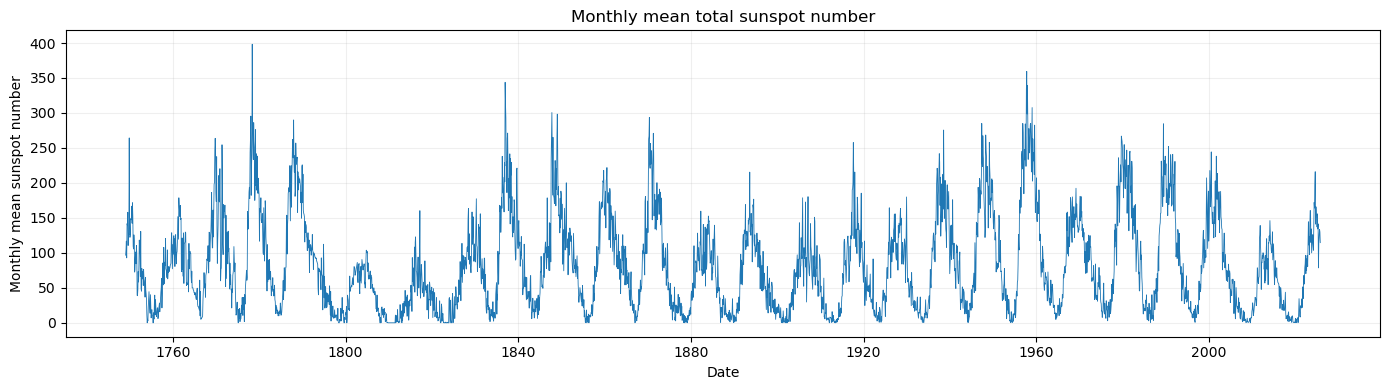

In [9]:
# ---------------- Step 1: Plot time series ----------------
plt.figure(figsize=(14,4))
plt.plot(dates, y, lw=0.6)
plt.title("Monthly mean total sunspot number")
plt.xlabel("Date")
plt.ylabel("Monthly mean sunspot number")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



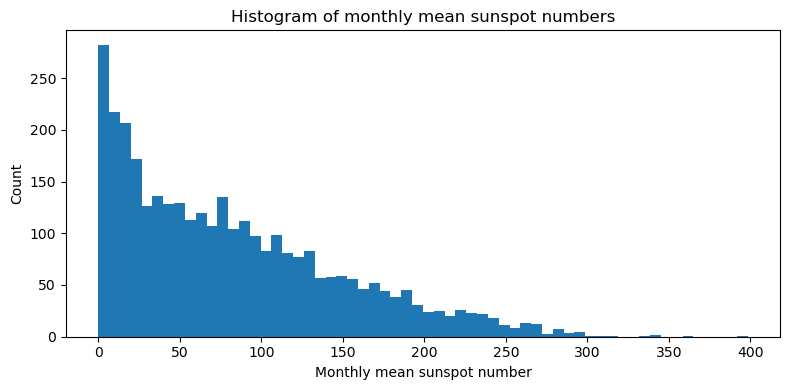

In [10]:
# ---------------- Step 3: Histogram ----------------
plt.figure(figsize=(8,4))
plt.hist(y, bins=60)
plt.title("Histogram of monthly mean sunspot numbers")
plt.xlabel("Monthly mean sunspot number")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [11]:
# ---------------- Step 2: Split into 12-year cycles ----------------
n = len(y)
num_cycles = int(np.ceil(n / CYCLE_LEN))
cycles = [y[i*CYCLE_LEN:(i+1)*CYCLE_LEN] for i in range(num_cycles)]
print("Total months:", n)
print("Cycle length (months):", CYCLE_LEN)
print("Number of 12-year cycles:", num_cycles)
for i,c in enumerate(cycles):
    print(f"Cycle {i+1}: {len(c)} months, mean={np.mean(c):.2f}, var={np.var(c):.2f}")



Total months: 3322
Cycle length (months): 144
Number of 12-year cycles: 24
Cycle 1: 144 months, mean=72.12, var=2104.25
Cycle 2: 144 months, mean=100.48, var=3434.30
Cycle 3: 144 months, mean=95.74, var=6844.40
Cycle 4: 144 months, mean=115.23, var=5084.77
Cycle 5: 144 months, mean=40.25, var=900.73
Cycle 6: 144 months, mean=31.52, var=937.58
Cycle 7: 144 months, mean=55.66, var=2139.55
Cycle 8: 144 months, mean=94.23, var=6463.67
Cycle 9: 144 months, mean=100.86, var=4817.90
Cycle 10: 144 months, mean=92.04, var=3319.04
Cycle 11: 144 months, mean=86.06, var=6128.52
Cycle 12: 144 months, mean=63.91, var=2133.96
Cycle 13: 144 months, mean=58.00, var=2305.09
Cycle 14: 144 months, mean=57.68, var=2056.14
Cycle 15: 144 months, mean=83.84, var=3110.66
Cycle 16: 144 months, mean=89.38, var=4585.08
Cycle 17: 144 months, mean=103.63, var=5255.81
Cycle 18: 144 months, mean=115.03, var=10189.44
Cycle 19: 144 months, mean=83.76, var=2783.78
Cycle 20: 144 months, mean=109.52, var=6343.80
Cycle 21:

In [12]:
# ---------------- Helper: Gamma MLE (for initial guess) ----------------
def gamma_mle(x):
    x = np.asarray(x) + EPS
    mean = x.mean()
    var = x.var()
    # robust method-of-moments initial guess
    a0 = max(mean*mean / (var+1e-8), 1e-3)
    b0 = max(var / (mean+1e-8), 1e-3)
    def nll(params):
        a, b = params
        if a <= 0 or b <= 0:
            return 1e12
        return -np.sum(gamma.logpdf(x, a, scale=b))
    res = minimize(nll, x0=[a0,b0], bounds=((1e-8,None),(1e-8,None)))
    a_hat, b_hat = res.x
    return a_hat, b_hat

# Compute initial MLEs for convenience and print
a_mle, b_mle = gamma_mle(y)
print("\nMLE (all data) -> a_hat={:.4f}, b_hat={:.4f}".format(a_mle, b_mle))

# ---------------- MCMC: Metropolis-Hastings for (a,b) ----------------
# We'll sample in log-space to ensure positivity: sample log_a, log_b, propose Gaussian steps.

def log_likelihood_ab(a, b, x):
    # Gamma log-likelihood (scipy's gamma uses shape a, scale b)
    if a <= 0 or b <= 0:
        return -np.inf
    return np.sum(gamma.logpdf(x, a, scale=b))

def log_prior_ab(a, b):
    # Weakly informative priors on a and b (log-normal-like behavior)
    # Center prior for a around 4 and b around 10 but reasonably wide:
    # equivalent to lognormal on a and b: log(a) ~ N(log(4), 1.0), log(b) ~ N(log(10), 1.0)
    if a <= 0 or b <= 0:
        return -np.inf
    lp_a = -0.5 * ((np.log(a) - np.log(4))**2) / (1.0**2) - np.log(a)  # include Jacobian for lognormal? not necessary for relative
    lp_b = -0.5 * ((np.log(b) - np.log(10))**2) / (1.0**2) - np.log(b)
    return lp_a + lp_b

def log_posterior_ab(a, b, x):
    return log_likelihood_ab(a,b,x) + log_prior_ab(a,b)

def mh_sampler(x, init_a, init_b, n_iter=N_ITER, prop_sd_log_a=PROP_SD_LOG_A, prop_sd_log_b=PROP_SD_LOG_B):
    samples = []
    log_a = np.log(init_a)
    log_b = np.log(init_b)
    current_a = np.exp(log_a)
    current_b = np.exp(log_b)
    current_logpost = log_posterior_ab(current_a, current_b, x)
    accept = 0
    for it in range(n_iter):
        # propose in log space
        prop_log_a = log_a + np.random.normal(0, prop_sd_log_a)
        prop_log_b = log_b + np.random.normal(0, prop_sd_log_b)
        prop_a = np.exp(prop_log_a)
        prop_b = np.exp(prop_log_b)
        prop_logpost = log_posterior_ab(prop_a, prop_b, x)
        # acceptance
        log_alpha = prop_logpost - current_logpost
        if np.log(np.random.rand()) < log_alpha:
            # accept
            log_a, log_b = prop_log_a, prop_log_b
            current_a, current_b = prop_a, prop_b
            current_logpost = prop_logpost
            accept += 1
        # store every step (we'll thin later)
        samples.append((current_a, current_b))
    acc_rate = accept / n_iter
    samples = np.array(samples)
    return samples, acc_rate




MLE (all data) -> a_hat=0.6680, b_hat=123.0034


In [13]:
# ---------------- Step 4: Run MCMC for three groups ----------------
groups = {
    "First 50": y[:50],
    "All": y,
    "Last 50": y[-50:]
}

mcmc_results = {}
for name, arr in groups.items():
    # handle tiny arrays or zero variance
    if len(arr) < 2:
        print("Skipping group", name, "— too few points.")
        continue
    a0, b0 = gamma_mle(arr)
    print(f"\nGroup: {name} size={len(arr)} ; MLE a0={a0:.4f}, b0={b0:.4f}")
    samples, acc_rate = mh_sampler(arr, init_a=max(a0,1e-3), init_b=max(b0,1e-3))
    print(f" MH finished. Acceptance rate ≈ {acc_rate:.3f}")
    # thin and drop burn-in
    samples_thinned = samples[BURN_IN::THIN, :]
    mcmc_results[name] = {"raw": samples, "thin": samples_thinned}
    print(f" Stored {samples_thinned.shape[0]} posterior samples after burn-in & thinning.")




Group: First 50 size=50 ; MLE a0=6.4168, b0=16.5889
 MH finished. Acceptance rate ≈ 0.681
 Stored 6400 posterior samples after burn-in & thinning.

Group: All size=3322 ; MLE a0=0.6680, b0=123.0034
 MH finished. Acceptance rate ≈ 0.269
 Stored 6400 posterior samples after burn-in & thinning.

Group: Last 50 size=50 ; MLE a0=7.6843, b0=15.1233
 MH finished. Acceptance rate ≈ 0.662
 Stored 6400 posterior samples after burn-in & thinning.


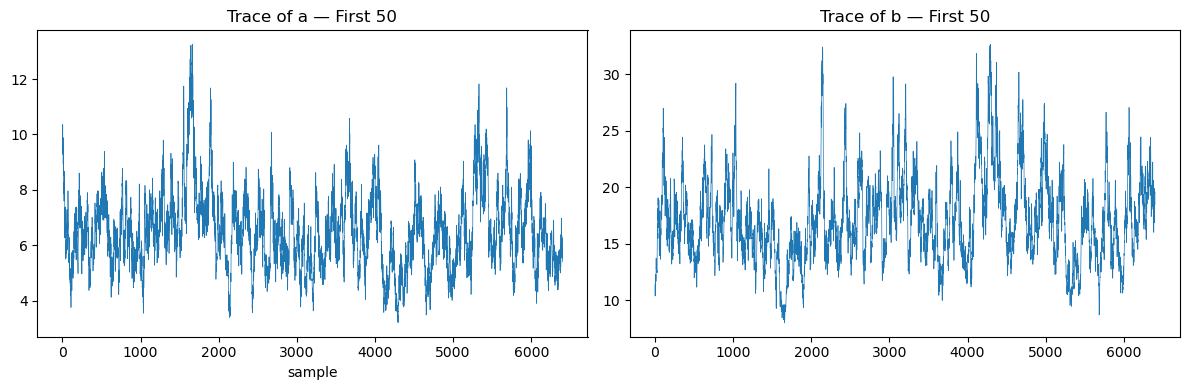

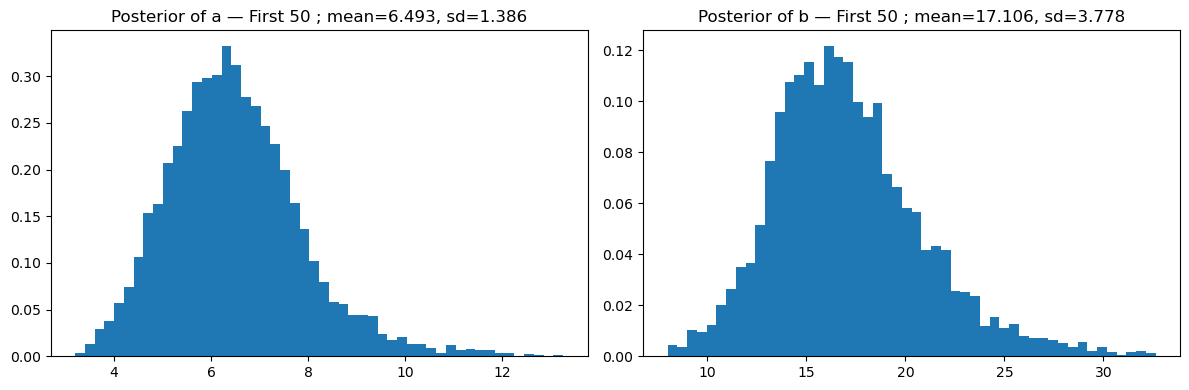

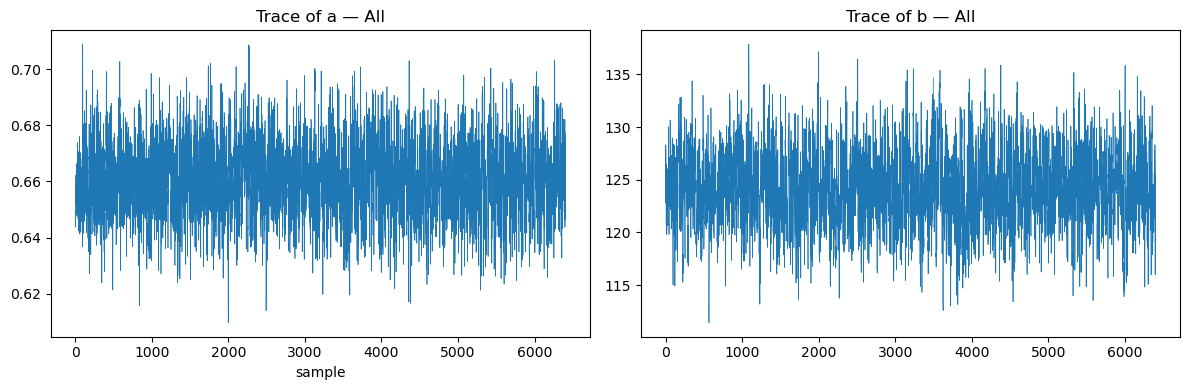

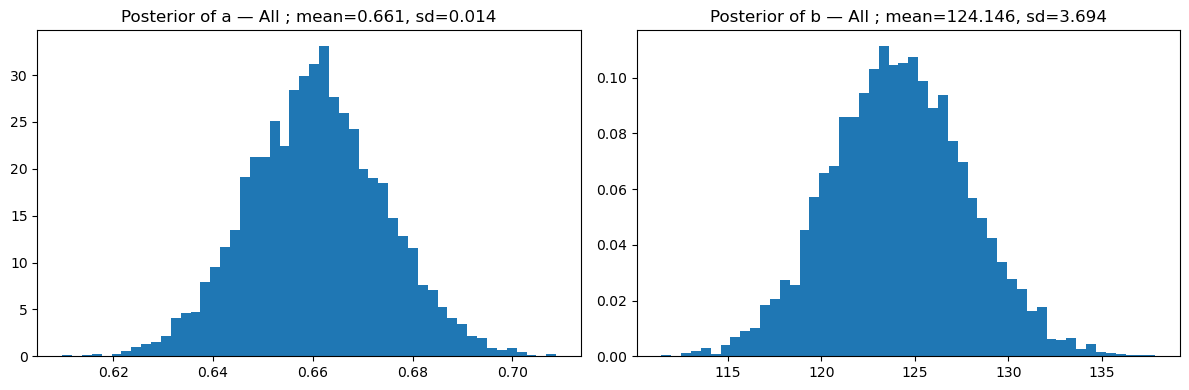

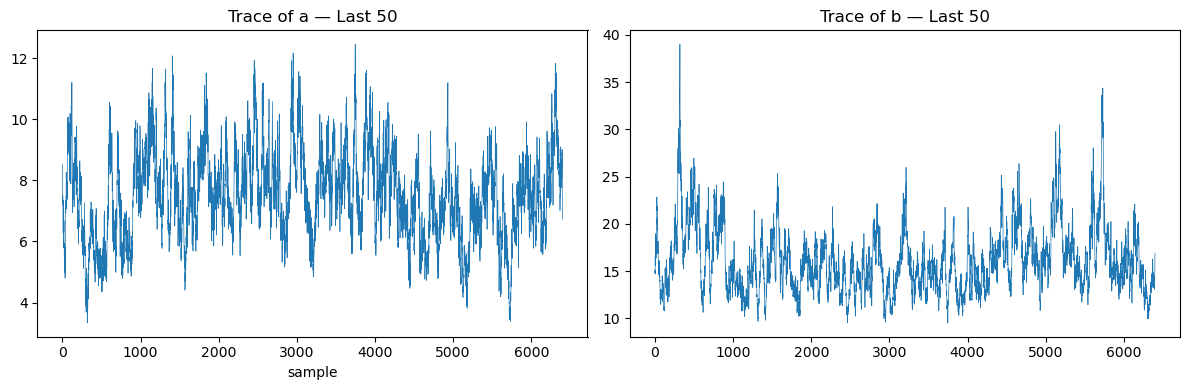

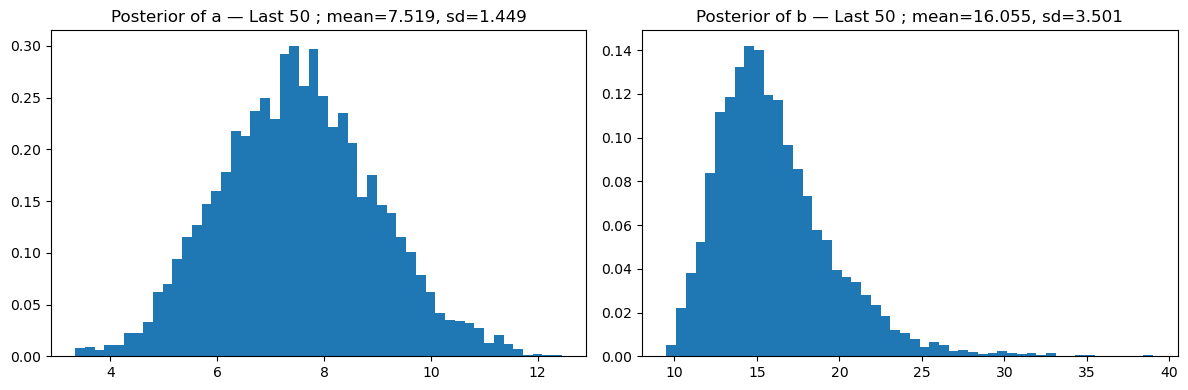

In [14]:
# ---------------- Step 5: Plot traces and histograms, drop burn-in ----------------
for name, info in mcmc_results.items():
    samples = info["thin"]
    a_samples = samples[:,0]
    b_samples = samples[:,1]

    # Trace plots (thin trace)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(a_samples, lw=0.5)
    plt.title(f"Trace of a — {name}")
    plt.xlabel("sample")
    plt.subplot(1,2,2)
    plt.plot(b_samples, lw=0.5)
    plt.title(f"Trace of b — {name}")
    plt.tight_layout()
    plt.show()

    # Histogram of posterior samples
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(a_samples, bins=50, density=True)
    plt.title(f"Posterior of a — {name} ; mean={a_samples.mean():.3f}, sd={a_samples.std():.3f}")
    plt.subplot(1,2,2)
    plt.hist(b_samples, bins=50, density=True)
    plt.title(f"Posterior of b — {name} ; mean={b_samples.mean():.3f}, sd={b_samples.std():.3f}")
    plt.tight_layout()
    plt.show()

    # save summaries
    mcmc_results[name]["a_mean"] = a_samples.mean()
    mcmc_results[name]["a_std"] = a_samples.std()
    mcmc_results[name]["b_mean"] = b_samples.mean()
    mcmc_results[name]["b_std"] = b_samples.std()




Using 6400 posterior samples from 'All' for posterior predictive.


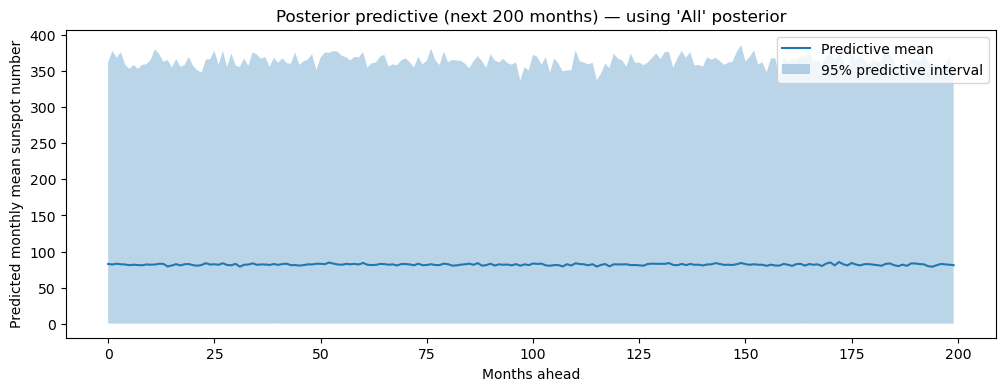

Prediction summary (first predicted month):
 mean = 82.881
 95% CI = [0.497, 362.214]

Posterior summary (All):
 a mean=0.6607, sd=0.0136
 b mean=124.1460, sd=3.6941

Finished. mcmc_results dict contains summaries and samples for each group.


In [15]:
# ---------------- Step 6: Posterior predictive & predictions for (a,b) ----------------
# Use posterior samples from "All" group for predictive checks (if present)
if "All" in mcmc_results:
    all_samps = mcmc_results["All"]["thin"]
    n_post = all_samps.shape[0]
    print("\nUsing", n_post, "posterior samples from 'All' for posterior predictive.")
    # For each posterior sample, draw a predictive vector of length L (we'll predict 200 months)
    L = 200
    preds = np.zeros((n_post, L))
    for i, (a_s, b_s) in enumerate(all_samps):
        preds[i] = gamma.rvs(a_s, scale=b_s, size=L)
    pred_mean = preds.mean(axis=0)
    pred_lo = np.percentile(preds, 2.5, axis=0)
    pred_hi = np.percentile(preds, 97.5, axis=0)

    # Plot predictive summary for L months
    plt.figure(figsize=(12,4))
    plt.plot(pred_mean, label="Predictive mean")
    plt.fill_between(np.arange(L), pred_lo, pred_hi, alpha=0.3, label="95% predictive interval")
    plt.title(f"Posterior predictive (next {L} months) — using 'All' posterior")
    plt.xlabel("Months ahead")
    plt.ylabel("Predicted monthly mean sunspot number")
    plt.legend()
    plt.show()

    # Print numeric summary for predicted distribution (first month as example)
    print("Prediction summary (first predicted month):")
    print(f" mean = {pred_mean[0]:.3f}")
    print(f" 95% CI = [{pred_lo[0]:.3f}, {pred_hi[0]:.3f}]")

    # Posterior summary for a and b
    a_post = all_samps[:,0]
    b_post = all_samps[:,1]
    print("\nPosterior summary (All):")
    print(f" a mean={a_post.mean():.4f}, sd={a_post.std():.4f}")
    print(f" b mean={b_post.mean():.4f}, sd={b_post.std():.4f}")
else:
    print("No 'All' posterior found — cannot compute posterior predictive.")

# ---------------- Done ----------------
print("\nFinished. mcmc_results dict contains summaries and samples for each group.")
